In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt

# Import FMLC
sys.path.append(os.path.join('..'))
from fmlc.triggering import triggering
from fmlc.baseclasses import eFMU
from fmlc.stackedclasses import controller_stack
from fmlc.utility import check_error

![Architecture](../documentation/architecture.jpg)

In [2]:
from Controllers_Definition import communication_dummy, forecaster_dummy, controller_dummy

In [3]:
# Setup control modules
controller = {}
# Slow loop (5 s sampletime)
controller['getweather'] = {'function':communication_dummy, 'sampletime':5}
controller['getgrid'] = {'function':communication_dummy, 'sampletime':'getweather'}
controller['forecast'] = {'function':forecaster_dummy, 'sampletime':'getgrid'}
controller['setgrid'] = {'function':communication_dummy, 'sampletime':'forecast'}
# Fast loop (1 s sampletime)
controller['getscada'] = {'function':communication_dummy, 'sampletime':1}
controller['controller'] = {'function':controller_dummy, 'sampletime':'getscada'}
controller['setscada'] = {'function':communication_dummy, 'sampletime':'controller'}

# Link control
mapping = {}
# Slow loop
mapping['getweather_mode'] = 'get_weather'
mapping['getgrid_mode'] = 'get_iso'
mapping['forecast_wf'] = 'getweather_data'
mapping['forecast_scada'] = 'getscada_data'
mapping['setgrid_mode'] = 'set_iso'
# Fast loop
mapping['getscada_mode'] = 'get_scada'
mapping['controller_data'] = 'forecast_data'
mapping['setscada_mode'] = 'set_scada'

### Run MGC

2024-01-02 17:44:25 DEBUG    SetupDB
 (fmlc.stackedclasses:__initialize_database)
2024-01-02 17:44:25 DEBUG    Execution list: [{'controller': ['getscada', 'controller', 'setscada'], 'next': 1704217461.9781141, 'running': False}, {'controller': ['getweather', 'getgrid', 'forecast', 'setgrid'], 'next': 1704217461.9781141, 'running': False}] (fmlc.stackedclasses:generate_execution_list)
2024-01-02 17:44:25 DEBUG    Execution map: {'getscada': 0, 'getweather': 1, 'controller': 0, 'getgrid': 1, 'setscada': 0, 'forecast': 1, 'setgrid': 1} (fmlc.stackedclasses:generate_execution_list)
2024-01-02 17:44:25 DEBUG    Executing Controller "getscada" (fmlc.stackedclasses:query_control)
2024-01-02 17:44:25 DEBUG    Executing Controller "getscada" (fmlc.stackedclasses:run_controller_queue)
2024-01-02 17:44:25 DEBUG    QueryCTRL getscada at 2024-01-02 09:44:25.021460224 (1704217465.0214603) (fmlc.stackedclasses:do_control)
2024-01-02 17:44:25 DEBUG    Executing Controller "controller" (fmlc.stackedcl

Log-keys: ['getweather', 'getgrid', 'forecast', 'setgrid', 'getscada', 'controller', 'setscada']
Log-messages from "controller"
                                                                            data  \
2024-01-02 09:44:21.978114048                                                NaN   
2024-01-02 09:44:25.021460224                                                 -1   
2024-01-02 09:44:26.090555136  {"P_load":{"1704153600000":15,"1704157200000":...   

                                            time         uid  \
2024-01-02 09:44:21.978114048                NaN         NaN   
2024-01-02 09:44:25.021460224   1704217465.02146  controller   
2024-01-02 09:44:26.090555136  1704217466.090555  controller   

                                                                         control  \
2024-01-02 09:44:21.978114048                                                NaN   
2024-01-02 09:44:25.021460224                                               None   
2024-01-02 09:44:26.090555

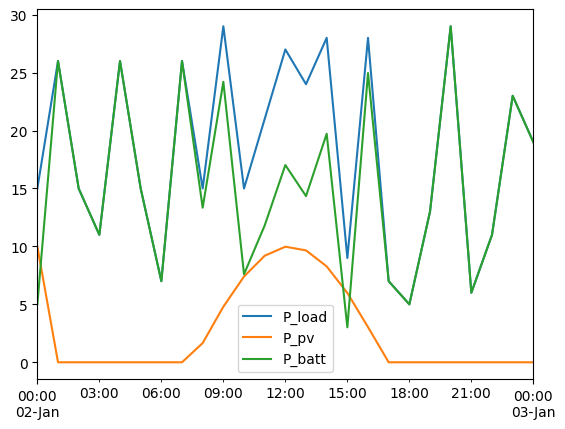

In [4]:
mgc = controller_stack(controller, mapping, debug=True, parallel=False)
for i in range(10):
    mgc.query_control(time.time())
    time.sleep(0.2)
log = mgc.log_to_df()
print('Log-keys:', list(log.keys()))
print('Log-messages from "controller"')
print(log['controller'])
df = pd.read_json(log['controller']['data'].iloc[-1])
df['P_batt'] = log['controller']['control'][-1]
df.plot()
plt.show()